# San Francisco Tax Rolls to SF Home Sales Dataset

## Limitations of back engineering sales from tax records

After your purchase, State law
(Proposition 13, passed in 1978)
requires our office to set a new
taxable value for your home. The
law says that this value, called the
assessed value, should reflect the
market value (not necessarily the
purchase price) of the property as
of the date of transfer. Every year
thereafter, your assessed value
cannot go up by more than 2% if
nothing has changed.

* How to estimate your new assessed value?

**If you paid market price for your
property, your new assessed value
will likely be the purchase price.**
However, there are times when
the price paid is not the market
value, such as property bought
under duress or property was **sold
at a below market price to family
members. In these cases, we are
required to use the market value.**
To plan conservatively, you can
research the sale prices of other
comparable properties in the same
neighborhood close to the date of
your purchase to estimate market
value.

### Takeaways:
* In the most cases new value == purchase price.
* If the purchase price is below market it is imputed with a valuation.
* If we use next year assessment as sale price, it is at most 2% higher than the "market" sale price.

Source: https://www.sfassessor.org/sites/default/files/uploaded/ASR_Factsheet_New%20Homeowner_Final.pdf

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-assessor-property-tax-rolls-2020/Assessor_Historical_Secured_Property_Tax_Rolls.csv


In [2]:
# Memory reduction helper function:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns
        col_type = df[col].dtypes
        if col_type in numerics: #numerics
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# Dataste from 2008 to 2020 (12 years)
df = reduce_mem_usage(
    pd.read_csv("/kaggle/input/sf-assessor-property-tax-rolls-2020/Assessor_Historical_Secured_Property_Tax_Rolls.csv"))

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Mem. usage decreased to 612.77 Mb (44.2% reduction)


## Basic Cleanup

In [4]:
clmn_names = [c.lower().replace(' ','_') for c in df.columns]
clmn_names_map = dict(zip(df.columns, clmn_names))
df.rename(columns=clmn_names_map, inplace=True)

In [5]:
# Remove homes where current sales date is unknown:
df = df[~df['current_sales_date'].isna()]

# Remove homes where current sales date older than 2008:
df['current_sales_date'] = pd.to_datetime(df['current_sales_date'])
df['sale_year'] = df['current_sales_date'].dt.year
df = df[df.sale_year>=df['closed_roll_year'].min()-1]

df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 609766 entries, 0 to 2666115
Data columns (total 55 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   closed_roll_year                      609766 non-null  int16         
 1   property_location                     609766 non-null  object        
 2   parcel_number                         609766 non-null  object        
 3   block                                 609766 non-null  object        
 4   lot                                   609765 non-null  object        
 5   volume_number                         609766 non-null  int8          
 6   use_code                              609186 non-null  object        
 7   use_definition                        609186 non-null  object        
 8   property_class_code                   609186 non-null  object        
 9   property_class_code_definition        609186 non-null  obj

In [6]:
df['id'] = (df['property_location'].astype(str) +
            df['parcel_number'].astype(str) +
            df['block'].astype(str) +
            df['lot'].astype(str))

In [7]:
# Properties are uniquely identified by 4 fields.
# Number of different properties:
df[['id']].drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85396 entries, 0 to 2666070
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      85396 non-null  object
dtypes: object(1)
memory usage: 1.3+ MB


In [8]:
# Number of sales is roughly 25% higher.
df[['id', 'sale_year']].drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111534 entries, 0 to 2666088
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         111534 non-null  object
 1   sale_year  111534 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.6+ MB


In [9]:
# Check out repeated sales. These could be flips!
df['sale_next_year'] = df.sale_year+1
prop_df = df[['id','sale_next_year']].drop_duplicates().copy()
prop_df = prop_df[['id','sale_next_year']].merge(
    df.drop_duplicates(),
    how='inner',
    left_on=['id','sale_next_year'],
    right_on=['id','sale_year'],
    suffixes = ('','_same_year')
)
prop_df.shape

(11765, 58)

In [10]:
df.columns

Index(['closed_roll_year', 'property_location', 'parcel_number', 'block',
       'lot', 'volume_number', 'use_code', 'use_definition',
       'property_class_code', 'property_class_code_definition',
       'year_property_built', 'number_of_bathrooms', 'number_of_bedrooms',
       'number_of_rooms', 'number_of_stories', 'number_of_units',
       'zoning_code', 'construction_type', 'lot_depth', 'lot_frontage',
       'property_area', 'basement_area', 'lot_area', 'lot_code',
       'tax_rate_area_code', 'percent_of_ownership', 'exemption_code',
       'exemption_code_definition', 'status_code', 'misc_exemption_value',
       'homeowner_exemption_value', 'current_sales_date',
       'assessed_fixtures_value', 'assessed_improvement_value',
       'assessed_land_value', 'assessed_personal_property_value',
       'assessor_neighborhood_district', 'assessor_neighborhood_code',
       'assessor_neighborhood', 'supervisor_district', 'analysis_neighborhood',
       'the_geom', 'row_id', 'sf_find_

In [11]:
df.rename(columns={'closed_roll_year': 'tax_year'}, inplace=True)

price_clmns = [
    'assessed_fixtures_value', 'assessed_improvement_value',
    'assessed_land_value', 'assessed_personal_property_value']

id_clmns = [
    'id',
    'property_location', 'parcel_number', 'block', 'lot',
    'sale_year','tax_year']

In [12]:
# Explore when the change on the assesed value happens - the same year or next year?
df[id_clmns+price_clmns].sort_values(by=['id','tax_year']).tail(50)

,id,property_location,parcel_number,block,lot,sale_year,tax_year,assessed_fixtures_value,assessed_improvement_value,assessed_land_value,assessed_personal_property_value
2134955,K000 0008 KEYSTONE WY0002A328203332...,K000 0008 KEYSTONE WY0002A,3282033,3282,033,2015,2015,0,179306,179306,0
315840,K000 0008 KEYSTONE WY0002A328203332...,K000 0008 KEYSTONE WY0002A,3282033,3282,033,2015,2016,0,251782,251782,0
526053,K000 0008 KEYSTONE WY0002A328203332...,K000 0008 KEYSTONE WY0002A,3282033,3282,033,2015,2017,0,256817,256817,0
2355881,K000 0008 KEYSTONE WY0002A328203332...,K000 0008 KEYSTONE WY0002A,3282033,3282,033,2017,2018,0,360000,360000,0
1012486,P000 0710 POWELL 00000256T050P0...,P000 0710 POWELL 0000,0256T050P,0256T,050P,2009,2009,0,1500,1500,0
1225455,P000 0710 POWELL 00000256T050P0...,P000 0710 POWELL 0000,0256T050P,0256T,050P,2009,2010,0,1500,1500,0
1704378,PH00 4658 18TH ST00002658077265...,PH00 4658 18TH ST0000,2658077,2658,077,2013,2013,0,518378,259482,0
1935661,PH00 4658 18TH ST00002658077265...,PH00 4658 18TH ST0000,2658077,2658,077,2013,2014,0,929199,929199,0
2138333,PH00 4658 18TH ST00002658077265...,PH00 4658 18TH ST0000,2658077,2658,077,2013,2015,0,947764,947764,0
310622,PH00 4658 18TH ST00002658077265...,PH00 4658 18TH ST0000,2658077,2658,077,2013,2016,0,962217,962217,0


## Creating dataset

In [13]:
prop_df = df[df.sale_year == (df.tax_year - 1)]

In [14]:
# Note that we have lost 14,000 ids.
prop_df.id.unique().shape

(70640,)

In [15]:
prop_df.to_csv("sf_home_sales_2020.csv")

## Small EDA

<AxesSubplot:>

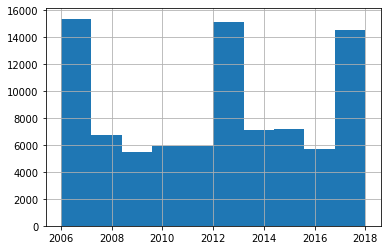

In [16]:
prop_df.sale_year.hist()

In [17]:
prop_df.construction_type.value_counts()

D      55027
C       2173
A       1327
B       1232
WOO      708
S        134
STE       95
F         20
ROW        2
REI        1
0          1
Name: construction_type, dtype: int64

In [18]:
# Pobably need to prune some of the property classes:
prop_df.property_class_code_definition.value_counts()

Condominium                            36136
Dwelling                               31570
Flats & Duplex                          5636
Live/Work Condominium                   2661
Apartment                               1896
                                       ...  
Bank Condominium                           1
Office Portion Leased of 35 or More        1
Shopping Center                            1
Office - "Trophy" Class A                  1
Office - High Class A                      1
Name: property_class_code_definition, Length: 91, dtype: int64

In [19]:
prop_df.use_definition.value_counts()

Single Family Residential    72251
Multi-Family Residential     11293
Commercial Misc               2196
Miscellaneous/Mixed-Use       1058
Commercial Retail              951
Industrial                     603
Commercial Office              570
Commercial Hotel               172
Government                       9
Name: use_definition, dtype: int64

In [20]:
# sf_find_neighborhoods_2 and neighborhoods are probably duplicates.
# maybe there are more duplicate columns?
prop_df.sf_find_neighborhoods_2.value_counts()

32.0     6334
39.0     3962
30.0     3604
53.0     3298
102.0    3213
         ... 
85.0       61
76.0       39
82.0       18
3.0         5
35.0        2
Name: sf_find_neighborhoods_2, Length: 113, dtype: int64

In [21]:
prop_df.neighborhoods.value_counts()

32.0     6334
39.0     3962
30.0     3604
53.0     3298
102.0    3213
         ... 
85.0       61
76.0       39
82.0       18
3.0         5
35.0        2
Name: neighborhoods, Length: 113, dtype: int64

<AxesSubplot:>

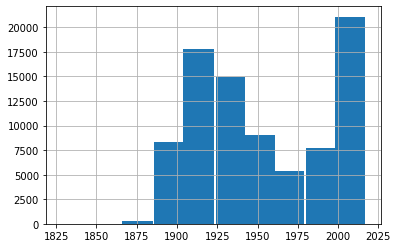

In [22]:
# property age might be an interesting feature (year_sale - year_property_built)
prop_df.year_property_built.hist()